In [51]:
# import packages
import torch
import yfinance as yf
import numpy as np
import paddle
import numpy as np
np.object = object
from paddle_quantum.gate import BasisEncoding, AmplitudeEncoding, AngleEncoding, IQPEncoding
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from torch import nn


[*********************100%***********************]  1 of 1 completed
I0116 16:07:53.758476 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.763387 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.765615 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.766706 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.766718 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.770648 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.771397 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.771405 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.774245 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.774361 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.774366 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:53.774

[0.00204423+0.j 0.00204286+0.j 0.0020461 +0.j ... 0.030575  +0.j
 0.03023697+0.j 0.02991338+0.j]


nel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128149 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128155 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128159 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128161 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128168 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128173 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128175 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128181 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128186 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128188 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128194 4266476096 kernel_dispatch.h:102] Get BackendSet from tensor
I0116 16:07:54.128199 4266476096 kernel_

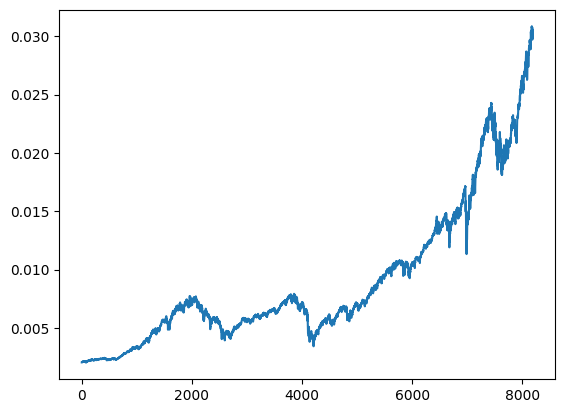

In [52]:
#load dataset
sp500 = yf.download('^GSPC', start='1992-06-19', end='2024-12-31')
close = sp500['Close']
open = sp500['Open']

# encode in state amplitude
# We have 8192 datapoints, so we need 13 qubits to encode them
qubits = 13

amplitude_enc = AmplitudeEncoding(num_qubits=qubits)
x = paddle.to_tensor(np.array(close))
state = amplitude_enc(x)
print(state)

data_im = state.numpy().tolist()
data = np.real(data_im)
plt.plot(data)

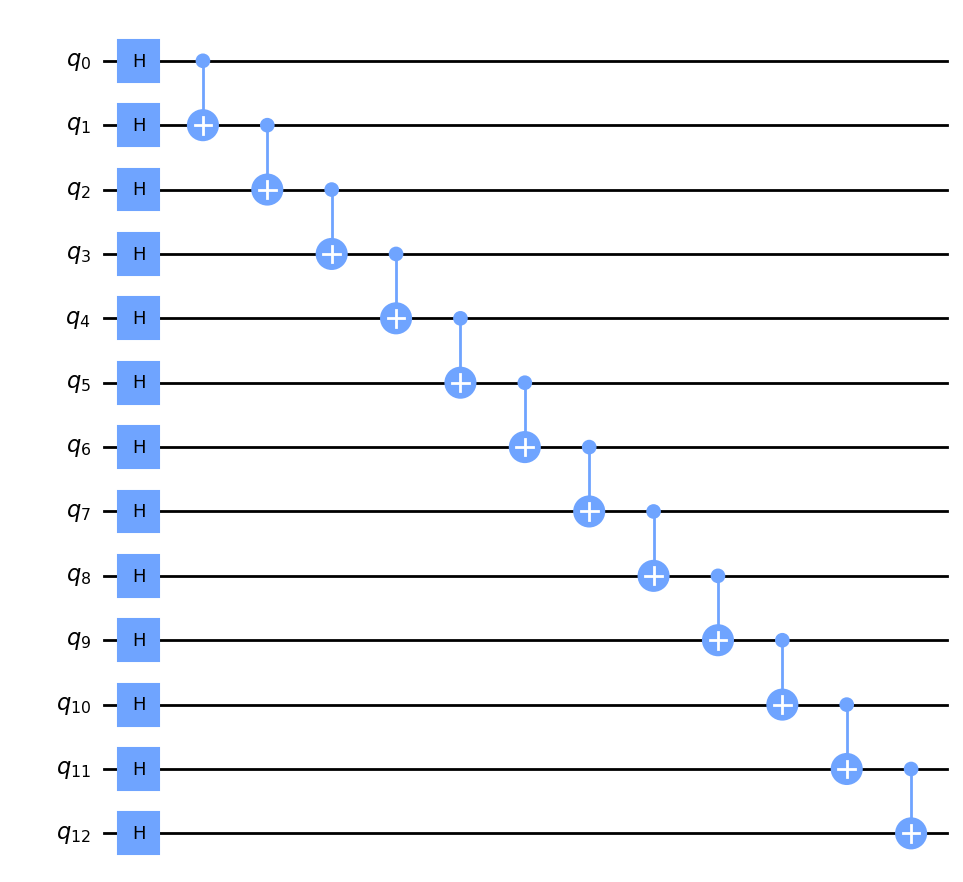

In [53]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RZGate, RXGate

# create the quantum circuit
qc = QuantumCircuit(qubits)

for qubit in range(qubits):
    qc.h(qubit)

for qubit in range(qubits - 1):
    qc.cx(qubit, qubit + 1)

qc.draw(output='mpl', style='clifford')

In [54]:
# define generator
class QuantumGenerator:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()

    def circuit_building(self, params):
        for layer in range(self.layers):
            for qubit in range(self.num_qubits):
                qc.rz(params[layer, qubit], qubit)
                qc.rx(params[layer, qubit + self.num_qubits], qubit)
        
        print(qc.num_parameters)
        return qc


# define discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 32)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [55]:
generator = QuantumGenerator(qubits)
discriminator = Discriminator(2)

In [56]:
# define loss functions
# BCE loss function
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

# WGAN loss function
def wgan_loss(pred, target_is_real):
    return -torch.mean(pred) if target_is_real else torch.mean(pred)

In [57]:
# add optimizers 

# SPSA optimizer

# Adam optimizer
from torch.optim import Adam

lr = 0.0001  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [58]:
# define plot function

In [59]:
# define training function